### Import and define functions

In [1]:
# Supress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Python
import matplotlib.pyplot as plt

# NumPy, PyTorch, sklearn
import torch
from torch.nn.functional import cosine_similarity
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.manifold import TSNE
x§
from sklearn.metrics import pairwise_distances

# Custom
from path_loader import PathDataLoader
from networks import SiameseNetworkSimple
from losses import ContrastiveLoss
from patch_generator import PatchGenerator

# Set random seeds
np.random.seed(0)

In [2]:
def train_siamese_network(data_train, data_val, net, criterion, optimizer, scheduler, val_batch_count, epochs=10):
    gamma = 1
    for epoch in range(epochs):
        for phase in ['val', 'train']:
            if phase == 'train':
                dataloader = data_train
            else:
                dataloader = data_val
            for i, data in enumerate(dataloader, 0):
                input1, input2 , original1, original2, feat1, feat2 = data
                output1, output2 = net(input1), net(input2)
                #gain as ref
                #ref1 = input1[:, -1]
                #ref2 = input2[:, -1]
                
                #cosine similarity as ref
                cos_sim=cosine_similarity(input1[:,:14],input2[:,:14])
                ref1=1-cos_sim
                ref2= torch.zeros_like(ref1)
                
                loss = criterion(output1, output2, ref1, ref2, gamma)
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            if phase == 'val':
                dataloader_object = iter(dataloader)
                data = []
                for i in range(val_batch_count):
                    data_batch = next(dataloader_object)
                    data.append(data_batch)
                embeddings = []
                for i in range(len(data)):
                    embeddings_temp1 = net(data[i][0])
                    embeddings_temp2 = net(data[i][1])
                    embeddings.append(embeddings_temp1)
                    embeddings.append(embeddings_temp2)
                trust_total = 0
                cont_total = 0
                for i in range(val_batch_count):
                    high_dimensional_distances1 = pairwise_distances(data[i][0], metric='euclidean')
                    high_dimensional_distances2 = pairwise_distances(data[i][1], metric='euclidean')

                    # Calculate the pairwise distances between points in the low-dimensional embedding space
                    low_dimensional_distances1 = pairwise_distances(embeddings[2 * i].detach().numpy(), metric='euclidean')
                    low_dimensional_distances2 = pairwise_distances(embeddings[2 * i + 1].detach().numpy(), metric='euclidean')

                    # Compute the trustworthiness score
                    trustworthiness_score1 = trustworthiness(high_dimensional_distances1, low_dimensional_distances1, n_neighbors=5)
                    trustworthiness_score2 = trustworthiness(high_dimensional_distances2, low_dimensional_distances2, n_neighbors=5)

                    trust_total += trustworthiness_score1
                    trust_total += trustworthiness_score2

                    continuity_score1 = np.corrcoef(high_dimensional_distances1.ravel(), low_dimensional_distances1.ravel())[0, 1]
                    continuity_score2 = np.corrcoef(high_dimensional_distances1.ravel(), low_dimensional_distances1.ravel())[0, 1]
                    
                    cont_total += continuity_score1
                    cont_total += continuity_score2


                print(f"Phase: {phase}, Epoch: {epoch}, Trustworthiness: {trust_total/(2*val_batch_count)}")
                print(f"Phase: {phase}, Epoch: {epoch}, Continuity: {cont_total/(2*val_batch_count)}")
        scheduler.step()

In [4]:
def generate_pairs(patches, patches_feat, ratio_local, num_pairs = 10000):
    num_patches = len(patches)
    ratio_nonlocal_pair = (1 - ratio_local) / (1 - (1 / num_patches))
    ratio_local_pair = 1 - ratio_nonlocal_pair
    
    data_pairs = []
    while len(data_pairs) < num_pairs:
      # Pick local pair or non-local pair
      first_patch_index = np.random.randint(num_patches)
      second_patch_index = np.random.randint(num_patches)
      rnd_local = np.random.uniform(0, 1)
      
      if rnd_local < ratio_local_pair:
        second_patch_index = first_patch_index
        
      # Pick a random path within a the chosen patch
      rnd_1 = np.random.randint(len(patches[first_patch_index]))
      rnd_2 = np.random.randint(len(patches[second_patch_index]))
    
      # In case we get same path
      if first_patch_index == second_patch_index:
        while rnd_1 == rnd_2:
          rnd_2 = np.random.randint(len(patches[second_patch_index]))

      data_pairs.append(
      (torch.tensor(patches[first_patch_index][rnd_1], dtype=torch.float), 
      torch.tensor(patches[second_patch_index][rnd_2], dtype=torch.float),
      torch.tensor(patches_feat[first_patch_index][rnd_1], dtype=torch.float),
      torch.tensor(patches_feat[second_patch_index][rnd_2], dtype=torch.float),
      torch.tensor(first_patch_index, dtype=torch.float),
      torch.tensor(second_patch_index, dtype=torch.float)))
    return data_pairs
    

In [5]:
def generate_dataloaders(data_pairs, train_val_ratio, batch_size):
    train_size = int(train_val_ratio * len(data_pairs))
    train_data = data_pairs[:train_size]
    val_data = data_pairs[train_size:]

    dataloaders_train = DataLoader(train_data, batch_size, shuffle=True)
    dataloaders_val = DataLoader(val_data, batch_size, shuffle=True)

    return dataloaders_train, dataloaders_val

In [6]:
def normalize_data(patches):
    num_paths_in_patches = []
    for i in patches:
        num_paths_in_patches.append(len(i))

    # Flatten the list -> Normalize every element
    flattened_patches = [value for patch in patches for path in patch for value in path]
    data_min = min(flattened_patches)
    data_max = max(flattened_patches)
    normalized_patches = [2 * ((x - data_min) / (data_max - data_min)) - 1 for x in flattened_patches]

    # Re-create the 3D list
    patches = [[] for i in range(len(num_paths_in_patches))]
    c = 0
    for i in range(len(num_paths_in_patches)):
        for j in range(num_paths_in_patches[i]):
            patches[i].append([])
            for k in range(21):
                patches[i][j].append(normalized_patches[c])
                c += 1
    return patches

### Load and preprocess data

In [3]:
# Load data
pathLoader = PathDataLoader()
paths = pathLoader.read('/mnt/c/Users/Admin/Ericsson-dd2430/eu_city_2x2_macro_306.bin')[:10000]
#paths = pathLoader.read('low_map_paths.bin')[:10000]

In [24]:
# Format data
batch_size = 256
train_val_ratio = 0.95
num_patches = 8
num_pairs = 100000
local_ratio = 0.5
val_batch_count = int(num_pairs * (1 - train_val_ratio) / batch_size)

#val batch count=4 and batch size=256 gives cleaner tsne plot of path manifold
val_batch_count=4

# Generate patches
gen = PatchGenerator(num_patches, attribute="transmitter")
patches = gen.generate_patches(paths)

# Transform PathPropagation objects to feature vectors
patches_feat = gen.transform_patches(patches)

patches_norm = normalize_data(patches_feat)

# Generate pairs
patches_pairs = generate_pairs(patches_norm, patches_feat, local_ratio, num_pairs)

#Create dataloaders
dataloader_train, dataloader_val = generate_dataloaders(patches_pairs, train_val_ratio, batch_size)

### Train model

In [31]:
# Instantiate the Siamese Network and Loss Function
lr=0.00001
net = SiameseNetworkSimple()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=2, gamma=0.9)   

train_siamese_network(dataloader_train, dataloader_val, net, criterion, optimizer, scheduler, val_batch_count, epochs=25)

Phase: val, Epoch: 0, Trustworthiness: 0.9534120621219758
Phase: val, Epoch: 0, Continuity: 0.8361894269066698
Phase: val, Epoch: 1, Trustworthiness: 0.9584799489667338
Phase: val, Epoch: 1, Continuity: 0.8622369521627772
Phase: val, Epoch: 2, Trustworthiness: 0.9403773153981854
Phase: val, Epoch: 2, Continuity: 0.7932429585659377
Phase: val, Epoch: 3, Trustworthiness: 0.9177840694304435
Phase: val, Epoch: 3, Continuity: 0.7874937706424002
Phase: val, Epoch: 4, Trustworthiness: 0.8762010143649194
Phase: val, Epoch: 4, Continuity: 0.7646392681624447
Phase: val, Epoch: 5, Trustworthiness: 0.8711445470010081
Phase: val, Epoch: 5, Continuity: 0.7128183013607706
Phase: val, Epoch: 6, Trustworthiness: 0.8549568422379032
Phase: val, Epoch: 6, Continuity: 0.743136989345618
Phase: val, Epoch: 7, Trustworthiness: 0.8549044701360887
Phase: val, Epoch: 7, Continuity: 0.7545097242117998
Phase: val, Epoch: 8, Trustworthiness: 0.8544386340725807
Phase: val, Epoch: 8, Continuity: 0.743369883581891
Pha

### Create embeddings

In [77]:
# Step 1 to visualize embeddings
times_batch = val_batch_count
assert val_batch_count >= times_batch

dataloader_object = iter(dataloader_val)
data = []
for i in range(val_batch_count):
    data_batch = next(dataloader_object)
    data.append(data_batch)

embeddings = []
color = []
path_descriptors=[]
for i in range(len(data)):
    embeddings_temp1 = net(data[i][0])
    embeddings_temp2 = net(data[i][1])
    embeddings.append(embeddings_temp1)
    embeddings.append(embeddings_temp2)
    
    #raw path data to be used for comparison using tsne
    raw_path_descriptors1= data[i][0]
    raw_path_descriptors2 = data[i][1]
    path_descriptors.append(raw_path_descriptors1)
    path_descriptors.append(raw_path_descriptors2)
    
    #choose 1 way of visualizing tsne plots below
    ###Colour according to gain
    #color.append(data[i][0][:,-1])
    #color.append(data[i][1][:,-1])
    
    ###cossim colouring - gives a lot of zero points because of ref2 maybe?
    #cos_sim=cosine_similarity(data[i][0][:,:14],data[i][1][:,:14])
    #ref1=cos_sim
    #ref2=cos_sim
    #color.append(ref1)
    #color.append(ref2)
    
    ###Colour according to patches
    color.append(data[i][4])
    color.append(data[i][5])

### Visualize embeddings

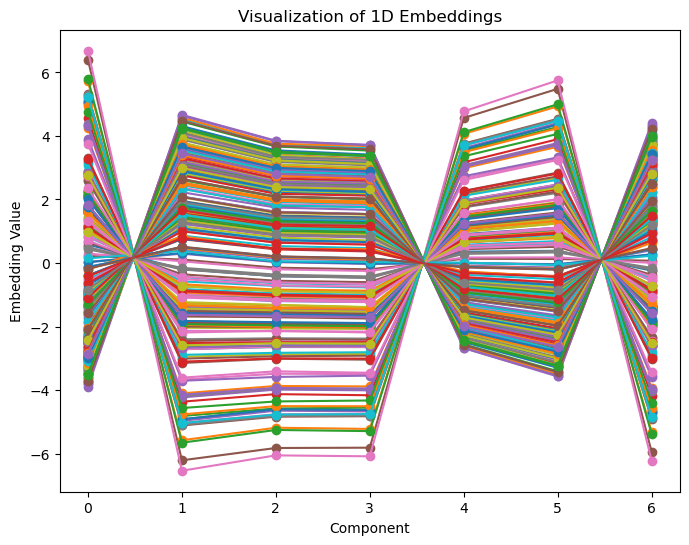

In [78]:
# Step 2 to visualize embeddings

# Convert embeddings to a list
embeddings_list = embeddings[0].squeeze().tolist()

# Create x-axis indices
indices = list(range(len(embeddings_list[0])))

# Plot the 1D embeddings
plt.figure(figsize=(8, 6))
for i in range(len(embeddings_list)):
    plt.plot(indices, embeddings_list[i], marker='o', linestyle='-')
plt.title('Visualization of 1D Embeddings')
plt.xlabel('Component')
plt.ylabel('Embedding Value')
plt.show()

t-SNE trustworthiness: 0.9997169404871323


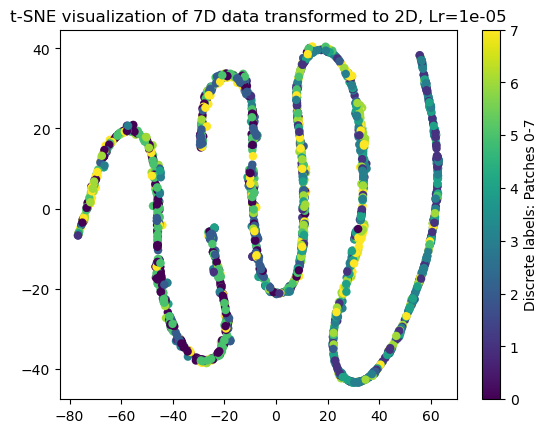

In [79]:
tsne = TSNE(n_components=2, random_state=0, perplexity=25)
embed_concat = [embeddings[0]]
for i in range(1, len(embeddings)):
    embed_concat.append(embeddings[i])
torch_concat = torch.cat(embed_concat, dim=0).detach().numpy()

X_2d = tsne.fit_transform(torch_concat)
color_np = torch.cat(color, dim=0).detach().numpy()


trustworthiness_tsne = trustworthiness(torch_concat, X_2d, n_neighbors=5)
print("t-SNE trustworthiness:", trustworthiness_tsne)

scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c = color_np, cmap='viridis',linewidths=0.05)
plt.colorbar(scatter, label='Discrete labels: Patches 0-7')
plt.title(f't-SNE visualization of 7D data transformed to 2D, Lr={lr}')
plt.show()

### Visualize raw path descriptors

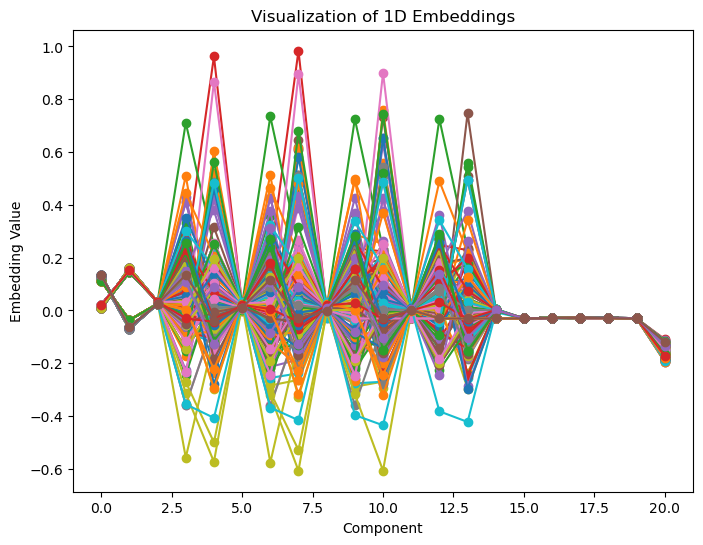

In [80]:
# Step 2 to visualize embeddings
embeddings=path_descriptors
# Convert embeddings to a list
embeddings_list = embeddings[0].squeeze().tolist()

# Create x-axis indices
indices = list(range(len(embeddings_list[0])))

# Plot the 1D embeddings
plt.figure(figsize=(8, 6))
for i in range(len(embeddings_list)):
    plt.plot(indices, embeddings_list[i], marker='o', linestyle='-')
plt.title('Visualization of 1D Embeddings')
plt.xlabel('Component')
plt.ylabel('Embedding Value')
plt.show()

t-SNE trustworthiness: 0.998590638403799


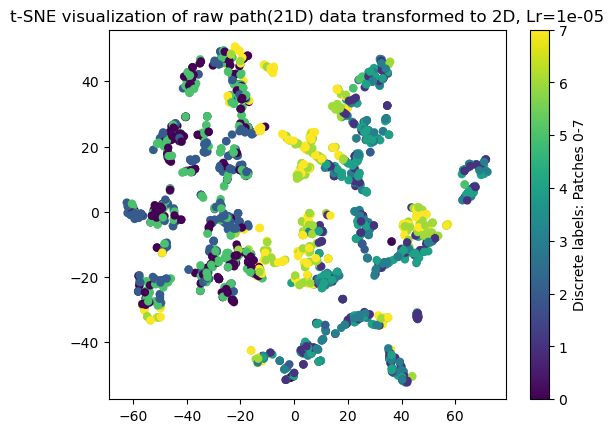

In [81]:
tsne = TSNE(n_components=2, random_state=0, perplexity=25)
embed_concat = [embeddings[0]]
for i in range(1, len(embeddings)):
    embed_concat.append(embeddings[i])
torch_concat = torch.cat(embed_concat, dim=0).detach().numpy()

X_2d = tsne.fit_transform(torch_concat)
color_np = torch.cat(color, dim=0).detach().numpy()


trustworthiness_tsne = trustworthiness(torch_concat, X_2d, n_neighbors=5)
print("t-SNE trustworthiness:", trustworthiness_tsne)

scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c = color_np, cmap='viridis',linewidths=0.05)
plt.colorbar(scatter, label='Discrete labels: Patches 0-7')
plt.title(f't-SNE visualization of raw path(21D) data transformed to 2D, Lr={lr}')
plt.show()

### Write data to files to be used in Blender

In [15]:
# WRITE TO FILES

file_original = open('original_data.txt', 'w')
file_embeddings = open('embeddings.txt', 'w')

dataloader_object = iter(dataloader_val)

with open('original_data.txt', 'a') as file:
    with open('embeddings.txt', 'a') as file2:
        for i in range(val_batch_count):
            data_batch = next(dataloader_object)

            embeddings1 = net(data_batch[0])
            embeddings2 = net(data_batch[1])

            embeddings1_txt = embeddings1.detach().numpy()
            embeddings2_txt = embeddings2.detach().numpy()

            for row in data_batch[2].numpy():
                file.write(' '.join([str(elem) for elem in row]) + '\n')
            for row in data_batch[3].numpy():
                file.write(' '.join([str(elem) for elem in row]) + '\n')
            for row in embeddings1_txt:
                file2.write(' '.join([str(elem) for elem in row]) + '\n')
            for row in embeddings2_txt:
                file2.write(' '.join([str(elem) for elem in row]) + '\n')

file_original.close()
file_embeddings.close()

In [16]:
print(val_batch_count)

9
